In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

CPU times: user 1.05 s, sys: 370 ms, total: 1.42 s
Wall time: 2.26 s


In [2]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,batch_size):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 16, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 16, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(16, 32, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

BATCH_SIZE=3000
GEN = Autoencoder(BATCH_SIZE)
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 16, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 16, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(16, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([16, 32, 8])
torch.Size([16])
torch.Size([16, 32, 8])
torch.Size([16])
torch.Size([16, 32, 8])
torch.Size([32])
torch.Size([32, 32,

In [3]:
GEN.load_state_dict(torch.load("GEN_WEIGHT_quarter.pkl"))

In [4]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

In [5]:
%%time
class Waveform():
    
    def __init__(self, path=None, select=1):
        if path is None:
            raise ValueError("Insert file path!")
        if select is None:
            raise ValueError("Pick 1 or 2!")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        label = np.load("label.npy")
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]

        waveform_n = normalize(pmtall,axis=1,norm="l2")
        self.waveform = waveform_n[label==select]
        
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]

dataset = Waveform(path="Run9goodDataQ_dualgate.root",select=4)

CPU times: user 42.2 s, sys: 3.97 s, total: 46.1 s
Wall time: 50.4 s


In [6]:
print(len(dataset))
data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=3)
del dataset

43785


In [7]:
correct_2 = np.array([1,2,1,2,2,1,2,2,1,1,2,1,1,2,2])

(3000, 256)


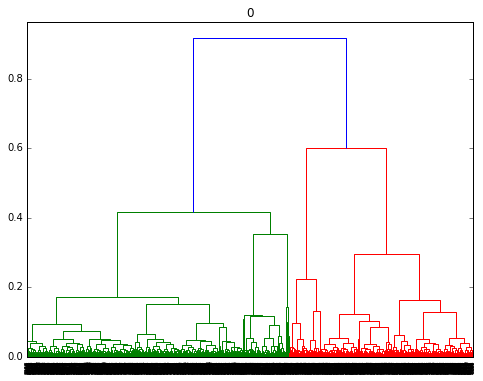

[1 2]


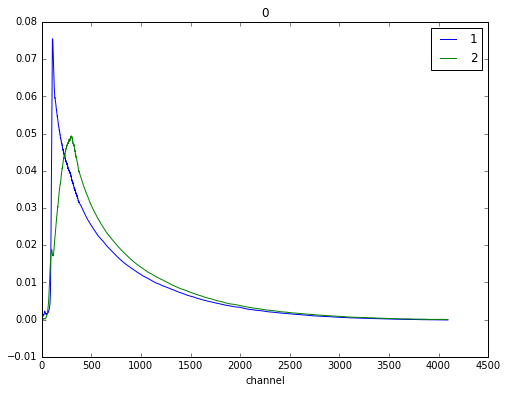

(3000, 256)


Process Process-2:
Process Process-1:
Process Process-3:


Training ended early.
CPU times: user 43.5 s, sys: 6.48 s, total: 50 s
Wall time: 49 s


Traceback (most recent call last):
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1467a0f60>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 178, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 8323) exited unexpectedly with exit code 1.
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _boots

In [8]:
%%time
label_2 = []
try:
    for batch_number, waveform in enumerate(data_loader):
        
        average = []
        average2 = []
#         average3 = []
#         average4 = []
        
        batch_size = waveform.size()[0]
        plotter = waveform.detach().numpy()
#         label = label.detach().numpy()
        
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
        encoder_feat = np.reshape(features[0].detach().numpy(),(batch_size,-1))
        print(encoder_feat.shape)
        Z = linkage(encoder_feat, method="ward")
#         print(Z.shape)
#         print(Z)
        fig = plt.figure(figsize=(8, 6))
        dn = dendrogram(Z)
        plt.title("{}".format(batch_number))
        plt.show()
        
        clusters = fcluster(Z, 0.7, criterion='distance')
#         print(clusters.shape)
#         print(clusters)
        print(np.unique(clusters))
    
        if correct_2[batch_number]==2:
            for i,j in enumerate(clusters):
                clusters[i] = 3 - clusters[i]
        
        label_2.append(clusters)
        
        
        for i, waveform_out in enumerate(features[0]):
#             plt.figure(figsize=(6, 4))
#             plt.plot(plotter[i])
#             plt.show()
            if clusters[i]==1:
                average.append(plotter[i])
                
            if clusters[i]==2:
                average2.append(plotter[i])
            
#             if clusters[i]==3:
#                 average3.append(plotter[i])
                
#             if clusters[i]==4:
#                 average4.append(plotter[i])
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
#         dang3 = np.mean(average3, axis=0)
#         dang4 = np.mean(average4, axis=0)
        
        plt.figure(figsize=(8,6))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
#         plt.plot(dang3,label="3")
#         plt.plot(dang4,label="4")
        plt.xlabel("channel")
        plt.legend()
        plt.title(batch_number)
        plt.show()

        

except KeyboardInterrupt:
    print('Training ended early.')

In [26]:
# print(label_2)
print(label_2[0])
labelling = np.empty(43785)

for i in range(15):
    if i==14:
        labelling[i*3000:] = label_2[i]
    else:
        labelling[i*3000:(i+1)*3000] = label_2[i]

[2 1 1 ... 1 2 2]


In [27]:
print(labelling)

[2. 1. 1. ... 2. 2. 1.]


In [28]:
labelling = labelling.astype(int)

In [29]:
np.save("label_4",labelling)